In [6]:
import sys
import platform
print(f'Dijalankan pada:\n{sys.version}\n{platform.platform()}')

Dijalankan pada:
3.11.9 (tags/v3.11.9:de54cf5, Apr  2 2024, 10:12:12) [MSC v.1938 64 bit (AMD64)]
Windows-10-10.0.22631-SP0


In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose

Pertanyaan:
- Apakah data mmemiliki kaidah seasonal dan trend?
- Pada musim apa rental sepeda paling banyak?
- Bagaimana temperatur (temp) mempengaruhi jumlah rental sepeda

## PreProcessing

### Input Data

In [42]:
df = pd.read_csv('data.csv')
df.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


fitur `Data season`, `yr`, `mnth`, `hr`, `holiday`, `weekday`, `workingday`, `weathersit` terlihat sebagai data kategorik, namun apa jarak dari fitur tersebut?

In [43]:
for column in df.columns[2:10]:
    print(f'{column}: {min(df[column].unique())} - {max(df[column].unique())}')

season: 1 - 4
yr: 0 - 1
mnth: 1 - 12
hr: 0 - 23
holiday: 0 - 1
weekday: 0 - 6
workingday: 0 - 1
weathersit: 1 - 4


Dapat disimpulkan, data yang berisikan ini 17 kolom ini memiliki detail fitur sebagai berikut:
- **instant**: Indeks unik untuk setiap pengamatan.
- **dteday**: Tanggal pengamatan dalam format YYYY-MM-DD.
- **season**: Musim dari pengamatan (1: Musim Semi, 2: Musim Panas, 3: Musim Gugur, 4: Musim Dingin).
- **yr**: Tahun pengamatan (0: 2011, 1: 2012).
- **mnth**: Bulan pengamatan (1 sampai 12).
- **hr**: Jam pengamatan (0 sampai 23).
- **holiday**: Apakah hari tersebut adalah hari libur (0: Bukan, 1: Ya).
- **weekday**: Hari dalam seminggu (0: Minggu, 1: Senin, ..., 6: Sabtu).
- **workingday**: Apakah hari tersebut adalah hari kerja (0: Bukan, 1: Ya).
- **weathersit**: Situasi cuaca (1: Cerah, 2: Berawan, 3: Hujan ringan, 4: Hujan lebat).
- **temp**: Suhu normalisasi dalam skala 0-1.
- **atemp**: Suhu yang dirasakan dalam skala 0-1.
- **hum**: Kelembaban dalam skala 0-1.
- **windspeed**: Kecepatan angin dalam skala 0-1.
- **casual**: Jumlah pengguna sepeda yang tidak terdaftar.
- **registered**: Jumlah pengguna sepeda yang terdaftar.
- **cnt**: Jumlah total pengguna sepeda (casual + registered).

Data terindikasi sebagai data time series.

Data akan melakukan feature dropping pada `instant`, `yr`, `mnth`, `holiday`, `temp`. Dengan alasan sebagai berikut:
- **instant**: Yang merupakan sebagai indeks amatan saja dan tidak memberikan informasi spesifik pada observasi
- **yr**: Merupakan tahun, sudah diinterpretasikan menggunakan `dteday`
- **mnth**: Merupakan bulan, sudah diinterpretasikan menggunakan `dteday`
- **holiday**: Dapat diinterpretasikan menggunakan `workingday`
- **temp**: Telah direpresentasi menggunakan `atemp`


Dilanjutkan dengan pengubahan tipe data kolom `dteday` digabung bersama `hr` menjadi tipe data `datetime`

In [44]:
df['datetime'] = pd.to_datetime(df['dteday']) + pd.to_timedelta(df['hr'], unit='h')
columns_to_remove = ['dteday', 'hr', 'instant', 'yr', 'mnth', 'holiday', 'atemp']
df =  df.drop(columns=columns_to_remove)
df.head()

,season,weekday,workingday,weathersit,temp,hum,windspeed,casual,registered,cnt,datetime
0,1,6,0,1,0.24,0.81,0.0,3,13,16,2011-01-01 00:00:00
1,1,6,0,1,0.22,0.80,0.0,8,32,40,2011-01-01 01:00:00
2,1,6,0,1,0.22,0.80,0.0,5,27,32,2011-01-01 02:00:00
3,1,6,0,1,0.24,0.75,0.0,3,10,13,2011-01-01 03:00:00
4,1,6,0,1,0.24,0.75,0.0,0,1,1,2011-01-01 04:00:00


### Handling and Cleaning

In [28]:
# Mengecek missing value
df.isna().sum()

season        0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
datetime      0
dtype: int64

Setelah menjalankan `df.isna().sum()`. Dapat dikatakan bila jumlah nilai yang hilang (missing values) di setiap kolom dalam dataframe `df` berjumlah sebanyak 0. Hal ini berarti tidak ada nilai yang hilang dalam dataset ini. Sebaliknya, jika ada kolom yang memiliki nilai lebih dari 0, maka kolom tersebut memiliki nilai yang hilang dan perlu ditangani lebih lanjut.

In [29]:
# Mengecek data duplikat
df.duplicated().sum()

0

In [30]:
# Mengecek jumlah data duplikat
jumlah_duplikat = df.duplicated().sum()
print(f'Jumlah data duplikat: {jumlah_duplikat}')

Jumlah data duplikat: 0


Pengecekan terhadap data duplikat menggunakan `df.duplicated().sum()`, ditemukan bahwa jumlah data duplikat dalam dataset adalah **0**. Hal ini berarti tidak ada data yang terduplikasi dalam dataset ini, sehingga tidak diperlukan tindakan lebih lanjut untuk menangani data duplikat.

## Eksplorasi

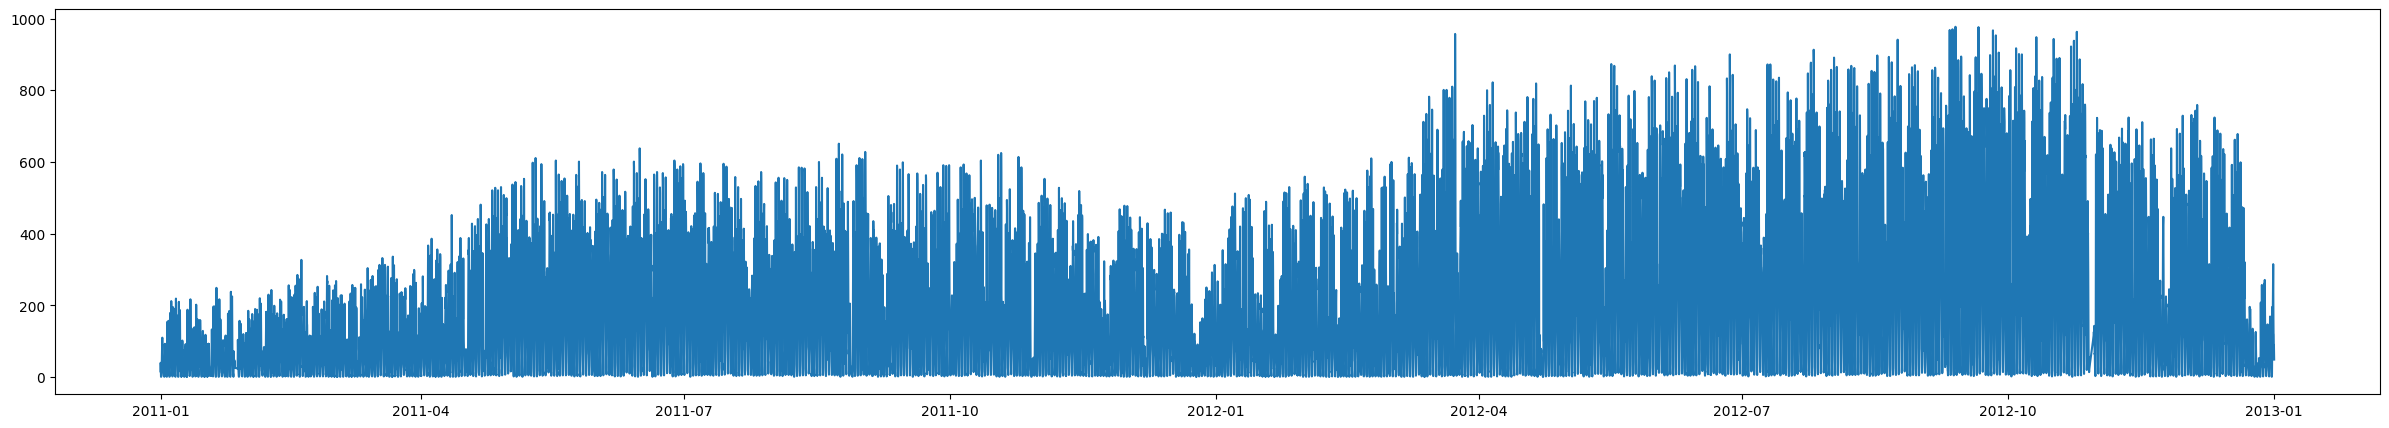

In [33]:
plt.figure(figsize=(30, 5))
plt.plot(df['datetime'], df['cnt'])

Plot yang telah dibuat menunjukkan jumlah total pengguna sepeda (`cnt`) terhadap waktu (`datetime`). Dari plot ini beberapa pola dan tren dalam penggunaan sepeda dapat diamati. Beberapa kesimpulan yang dapat diambil dari plot ini antara lain:

1. **Pola Musiman**: Terdapat fluktuasi musiman dalam penggunaan sepeda. Misalnya, penggunaan sepeda mungkin lebih tinggi selama bulan-bulan tertentu dan lebih rendah selama bulan-bulan lainnya.
2. **Pola Harian**: Penggunaan sepeda juga dapat menunjukkan pola harian, seperti peningkatan penggunaan selama jam sibuk (pagi dan sore hari) dan penurunan penggunaan selama jam non-sibuk.

Sehingga akan dilakukan eksplorasi lebih lanjut untuk memahami tren dan pola dalam data penggunaan sepeda ini.

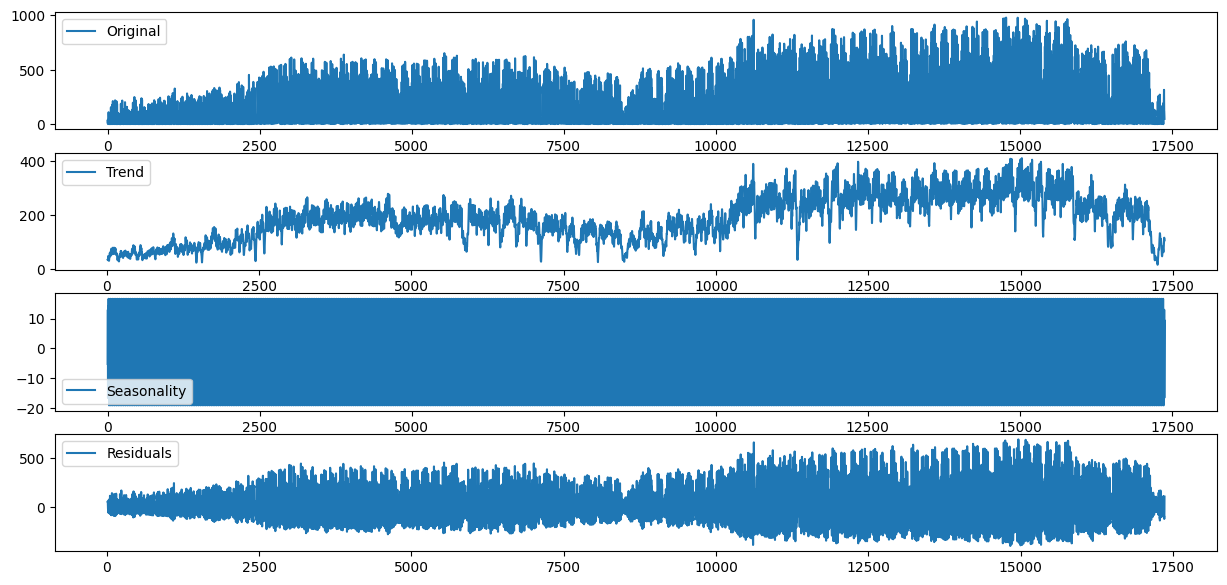

In [38]:
DecomposeResult = seasonal_decompose(df["cnt"], period=30)
trend = DecomposeResult.trend
seasonal = DecomposeResult.seasonal
residual = DecomposeResult.resid

def plot_decomposition(original, trend, seasonal, residual):
    """
    Plot the components of a decomposition. Pass in the original univarate data which was decomposed, and then the 
    3 resulting components, being the trend, seasonal and residual parts. 
    """
    # Plot the results
    fig = plt.figure(figsize=(15,7))
    ax = fig.add_subplot(4, 1, 1)
    ax.plot(original, label = 'Original')
    ax.legend(loc = 'best')
    ax = fig.add_subplot(4, 1, 2)
    ax.plot(trend, label = 'Trend')
    ax.legend(loc = 'best')
    ax = fig.add_subplot(4, 1, 3)
    ax.plot(seasonal, label = 'Seasonality')
    ax.legend(loc = 'best')
    ax = fig.add_subplot(4, 1, 4)
    ax.plot(residual, label = 'Residuals')
    ax.legend(loc = 'best')
    return

seasonality_plot = plot_decomposition(df["cnt"], trend, seasonal, residual)

Hasil decomposisi dari data `cnt` (jumlah total pengguna sepeda) menunjukkan beberapa komponen penting yang dapat membantu dalam memahami pola dan tren dalam data ini.

1. **Trend**:
    - Komponen trend menunjukkan arah umum dari data penggunaan sepeda selama periode waktu yang diamati. Hal ini membantu untuk memahami apakah penggunaan sepeda meningkat, menurun, atau tetap stabil dalam jangka panjang.
    - Pada hasil decomposisi ini, komponen trend (`trend`) meningkat seiring waktu, menunjukkan peningkatan jangka panjang pada nilai deret waktu, yang selaras dengan data asli.

2. **Seasonal**:
    - Pada hasil decomposisi ini, komponen seasonal (`seasonal`) terlihat hampir konstan dan mendekati nol, menunjukkan bahwa rangkaian waktu tersebut mungkin tidak menunjukkan musiman yang signifikan. Hal ini dapat menunjukkan tidak adanya pola berulang secara berkala.

3. **Residual**:
    - Komponen residual menunjukkan variasi acak atau noise dalam data yang tidak dapat dijelaskan oleh komponen trend atau seasonal. Berguna untuk mengidentifikasi anomali atau kejadian tak terduga dalam data.
    - Pada hasil decomposisi ini, komponen residual (`residual`) menjelaskan bila data masih mengandung fluktuasi yang tidak dapat dijelaskan oleh musiman atau tren.

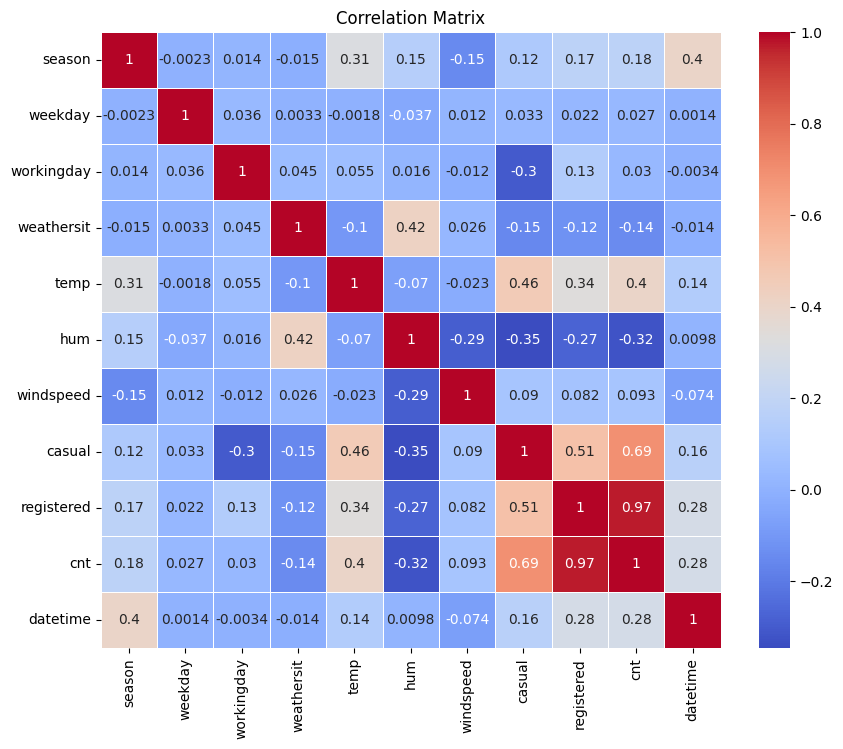

In [45]:
df.corr()
plt.figure(figsize=(10, 8))
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()